In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
def zero_outputs(df, outputs):
    copy_df = df.copy()
    copy_df[outputs] = copy_df[outputs]-copy_df[outputs].iloc[0,:]
    return copy_df

In [3]:
# Define common variables
outputs= ["CCO", "HbT", "Hbdiff", "HbO2", "HHb"]

# LWP484 #

In [4]:
lwp484_sim = pd.read_csv("../data/openopt_results/LWP484/fitting_run/bp_hypothermia/221118T1155/model_run_output_221118T1155.csv")

In [5]:
lwp484 =  pd.read_csv("../data/clean_hypothermia/LWP484_filtered_formatted.csv")

In [6]:
lwp484_zero = zero_outputs(lwp484_sim, outputs)

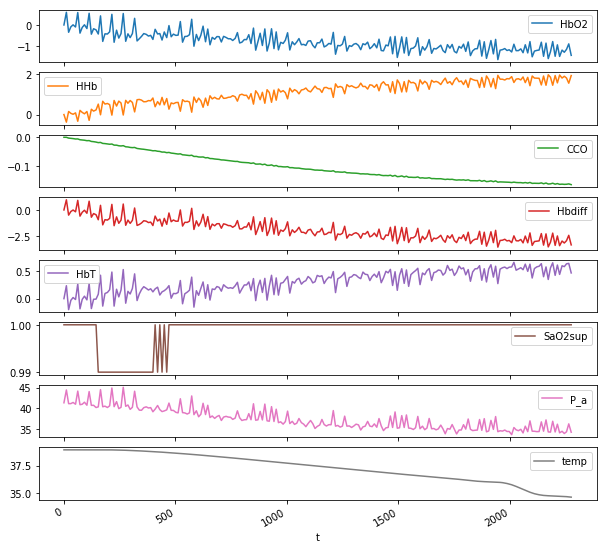

In [7]:
fig_sim = lwp484_zero.plot(x='t', subplots=True, figsize=(10,10))

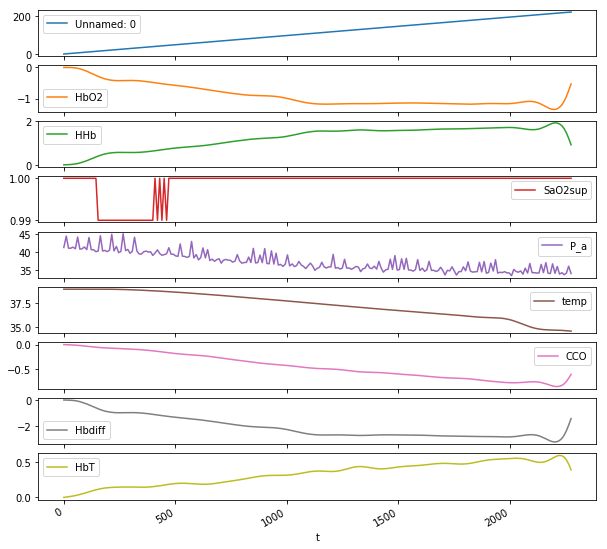

In [8]:
fig_true = lwp484.plot(x='t', subplots=True, figsize=(10,10))

In [9]:
def normalised_root_mean_square_error_dist(data1, data2):
    """Get the Normalised Root Mean Square Error distance between two numpy
    arrays.

    Parameters
    ----------
    data1 : np.ndarray
        First data array.

        The shape should match that of data2 and the number of rows should
        match the number of model outputs i.e. 2 model outputs will be two
        rows.

    data2 : np.ndarray
        Second data array.

        The shape should match that of data1 and the number of rows should
        match the number of model outputs i.e. 2 model outputs will be two
        rows. Should generally be the measured data i.e. d0.

    Returns
    -------
    d : float
    """
    try:
        assert (data1.shape == data2.shape), 'Arrays not of equal size'
    except AssertionError as e:
        print(e)
        print("\tData 1: ", data1.shape)
        print("\tData 2: ", data2.shape)
        raise e
    assert (data1.shape == data2.shape), 'Arrays not of equal size'

    # Get number of time points to average over.
    n = len(data2)

    rng = np.max(data2) - np.min(data2)
    try:
        d = np.sum(np.sqrt(1 / n * np.sum((data1 - data2) * (data1 - data2))) / rng)
    except ValueError as e:
        print(e)
        print("\tData 1: ", data1.shape)
        print("\tData 2: ", data2.shape)
        raise e
    return d

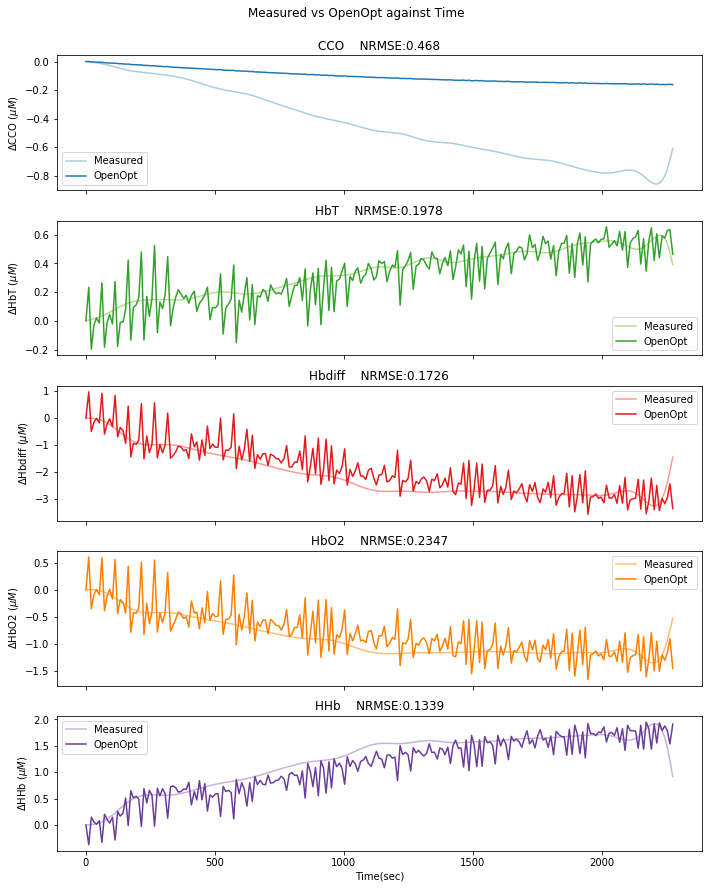

In [10]:
fig, axes = plt.subplots(nrows=len(outputs), figsize=(10,12))
colors=iter(sns.color_palette('Paired', 10))
for ii, output in enumerate(outputs):
    nrmse = normalised_root_mean_square_error_dist(lwp484_zero[output].values,lwp484[output].values)
    axes[ii].plot(lwp484['t'].values, lwp484[output].values, label='Measured', color=next(colors))

    axes[ii].plot(lwp484_zero['t'].values, lwp484_zero[output].values, label='OpenOpt', color=next(colors))
    axes[ii].set_title("{}    NRMSE:{:.4g}".format(output, nrmse))
    axes[ii].set_ylabel("$\Delta${} ($\mu M$)".format(output))
    axes[ii].legend()
    
for ax in axes[:-1]:
    plt.setp(ax.get_xticklabels(), visible=False)
axes[-1].set_xlabel("Time(sec)")
fig.suptitle("Measured vs OpenOpt against Time", y=1.025)
plt.tight_layout()
plt.show()
    

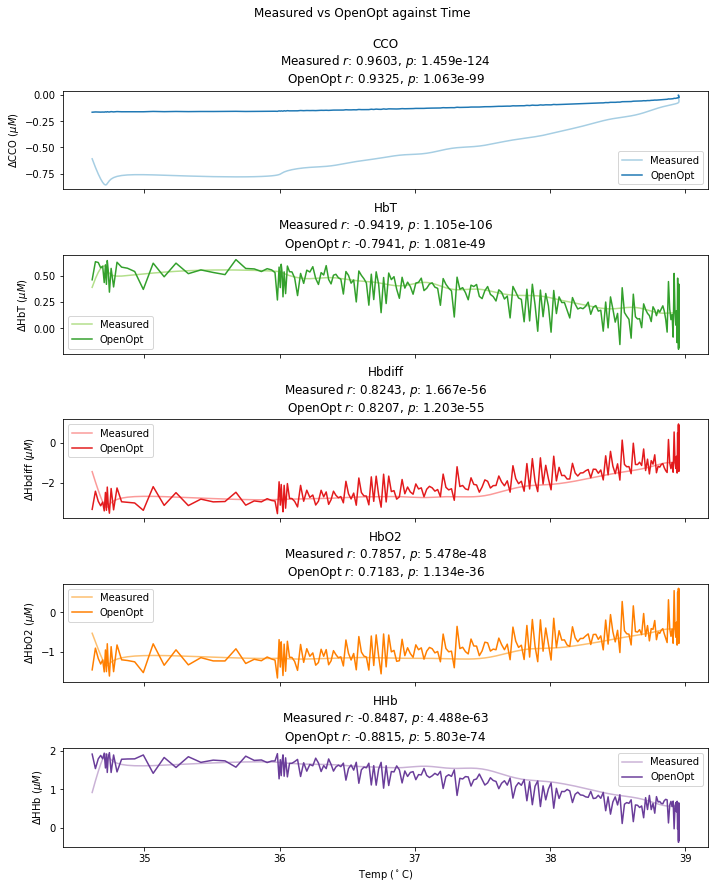

In [11]:
from scipy.stats import pearsonr
fig, axes = plt.subplots(nrows=len(outputs), figsize=(10,12))
colors=iter(sns.color_palette('Paired', 10))
for ii, output in enumerate(outputs):
    axes[ii].plot(lwp484['temp'].values, lwp484[output].values, label='Measured', color=next(colors))
    pearson_measured = pearsonr(lwp484['temp'].values, lwp484[output].values)
    axes[ii].plot(lwp484_zero['temp'].values, lwp484_zero[output].values, label='OpenOpt', color=next(colors))
    pearson_openopt = pearsonr(lwp484_zero['temp'].values, lwp484_zero[output].values)
    axes[ii].set_title("{}\nMeasured $r$: {:.4g}, $p$: {:.4g}\nOpenOpt $r$: {:.4g}, $p$: {:.4g}".format(output,
                                                                                                        pearson_measured[0],
                                                                                                        pearson_measured[1],
                                                                                                        pearson_openopt[0],
                                                                                                        pearson_openopt[1]))
    axes[ii].set_ylabel("$\Delta${} ($\mu M$)".format(output))
    axes[ii].legend()
    
for ax in axes[:-1]:
    plt.setp(ax.get_xticklabels(), visible=False)
axes[-1].set_xlabel("Temp ($^\circ$C)")
fig.suptitle("Measured vs OpenOpt against Time", y=1.025)
plt.tight_layout()
plt.show()

In [12]:
import json
config = json.load(open("../config_files/single_run/LWP484_openopt.json"))
fit_parameters = config['parameters']


In [13]:
from io import StringIO
default_params = StringIO("""NADpool, uniform, 2.4000, 3.6000, 3.0000
k_aut, uniform, 0.0000, 1.0000, 1.0000
P_an, uniform, 40.0000, 60.0000, 50.0000
P_ic, uniform, 3.6000, 5.4000, 4.5000
a_frac_n, uniform, 0.5360, 0.8040, 0.6700
Xtot_n, uniform, 4.3200, 6.4800, 5.4000
r_0, uniform, 0.0101, 0.0151, 0.0126
r_t, uniform, 0.0144, 0.0216, 0.0180
CMRO2_n, uniform, 0.0160, 0.0240, 0.0200
pH_on, uniform, 5.6000, 8.4000, 7.0000
temp_n, uniform, 35.0000, 39.0000, 37.0000
Q_10, uniform, 1.0000, 6.0000, 2.2300
phi, uniform, 0.0288, 0.0432, 0.0360
r_m, uniform, 0.0216, 0.0324, 0.0270
Dpsi_n, uniform, 116.0000, 174.0000, 145.0000
r_n, uniform, 0.0150, 0.0224, 0.0187
""")
default_parameters = pd.read_csv(default_params, header=None, names = ['Parameter', 'Type', 'Min', 'Max', 'Default'], index_col=0)
default_parameters['OpenOpt'] = pd.Series(fit_parameters)
default_parameters.reset_index(inplace=True)

In [14]:
melted_params = pd.melt(default_parameters, id_vars = ['Parameter', 'Type', 'Min', 'Max'], value_vars=['Default', 'OpenOpt'],
...         var_name='Kind', value_name='Value')

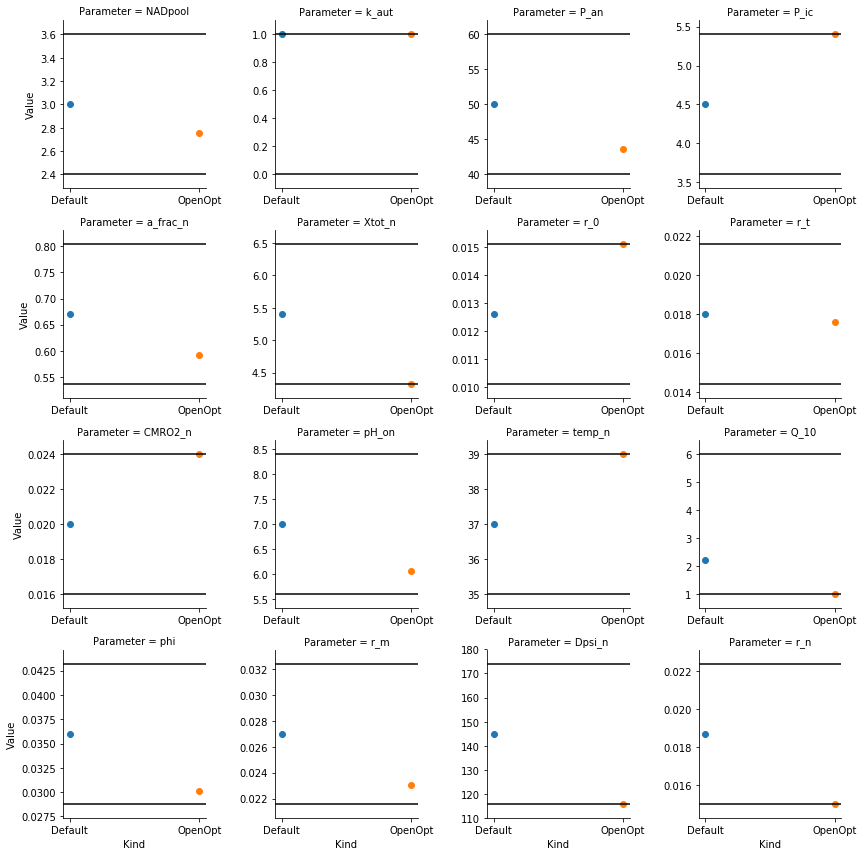

In [15]:
g = sns.FacetGrid(data=melted_params, col='Parameter', hue='Kind', col_wrap=4, sharex=False, sharey=False, legend_out=True)
g = g.map(plt.scatter, 'Kind', 'Value')
for ii, ax in enumerate(g.fig.axes):
    rng = melted_params['Max'].iloc[ii] - melted_params['Min'].iloc[ii]
    ax.set_ylim(melted_params['Min'].iloc[ii]-0.1*rng, melted_params['Max'].iloc[ii]+0.1*rng)
    ax.axhline(melted_params['Min'].iloc[ii], color='k')
    ax.axhline(melted_params['Max'].iloc[ii], color='k')

    